In [1]:
%matplotlib inline

In [2]:
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

from tqdm.auto import tqdm as pbar
from pathlib import Path


from ihrem.timeslice import Win, ms
from ihrem import paths
from ihrem.figs_comp import fig5

import logging
import warnings
warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.INFO)

reg = paths.Registry.read_excel(paths.get_root() / 'registry_merged.xlsx')
exp_events = reg.get_all_events()
print(f'Found {len(reg.experiment_names)} experiments')

Found 57 experiments


# Hists of peak corr (Fig. 5 d)

In [3]:
exp_names = [
    'GL1035_20210802',
    'GL1035_20210803',
    'GL1035_20210804',

    'GL1058_20210806',
    'GL1058_20210807',

    'GL1142_20210902',
    'GL1142_20210903',
    'GL1142_20210904',
]

In [4]:
%%time

from ihrem.analysis import xcorr_bestlags as xcb

USE_CACHE = True
MIN_XCORR_Q = .75

exp_best_lags = xcb.compute_lags_best_xcorr(reg, exp_names, fig_desc='fig5_lag_max_xcorr', use_cache=USE_CACHE)

probs = xcb.compute_dist_best_lags(exp_best_lags, min_xcorr_q=MIN_XCORR_Q)

loading cached best lags


loading:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 11.7 s, sys: 3.86 s, total: 15.5 s
Wall time: 17.3 s


Saving /gpfs/gjor/personal/riquelmej/dev/ihrem/notebooks/figs/figs/fig5_lag_max_xcorr_summary_0.75q.pdf


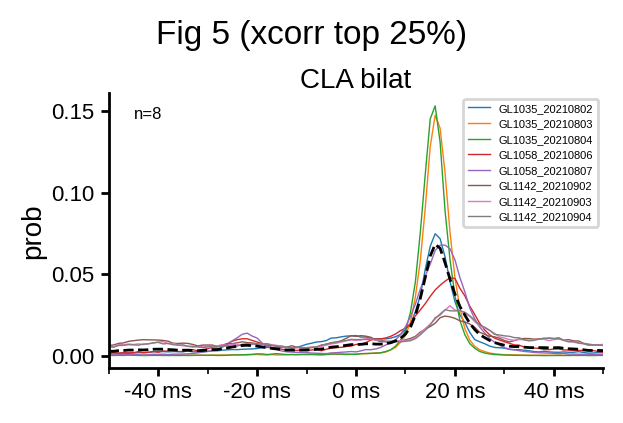

In [5]:
axs = xcb.plot_dists_best_lags(
    probs[['CLA bilat']],
    suptitle=f'Fig 5 (xcorr top {100*(1 - MIN_XCORR_Q):g}%)',
    figsize=(3, 2),
)

fig_path = Path(f'figs/fig5_lag_max_xcorr_summary_{MIN_XCORR_Q:g}q.pdf')
print(f'Saving {fig_path.absolute()}')
axs[0].figure.savefig(str(fig_path))

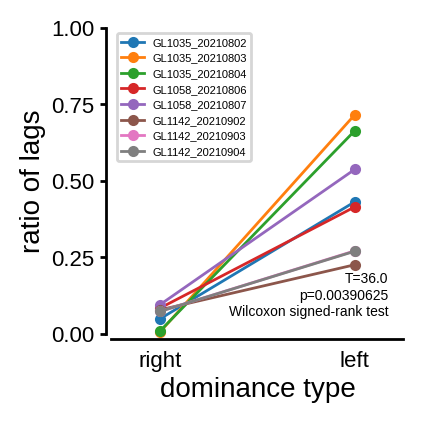

In [6]:
ax = fig5.plot_stat_test(
    fig5.take_cla_bilat_area(probs, 15, 25),
)
ax.figure.savefig(f'figs/fig5_lag_max_xcorr_stat_15_25.pdf')

## Other lesions (EDF 5 c & d)

loading cached best lags


loading:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Saving /gpfs/gjor/personal/riquelmej/dev/ihrem/notebooks/figs/figs/ctx_lesion_lag_max_xcorr.pdf


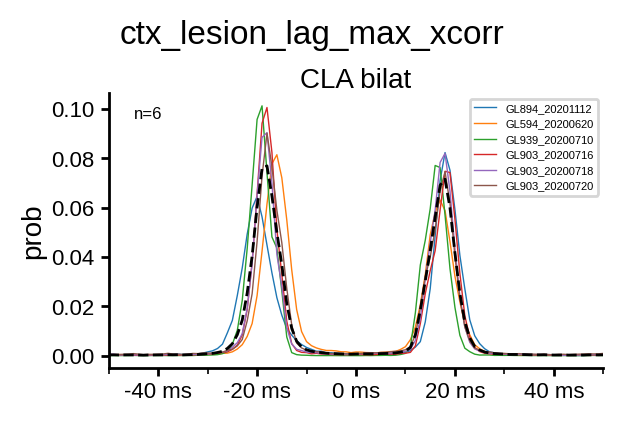

In [7]:
ctx_exp_names = [
    'GL894_20201112',
    'GL594_20200620',
    'GL939_20200710',
    'GL903_20200716',
    'GL903_20200718',
    'GL903_20200720',
]

fig5.plot_lesion_hists(
    reg,
    ctx_exp_names,
    fig_desc='ctx_lesion_lag_max_xcorr',
    min_xcorr_q=MIN_XCORR_Q,
    use_cache=USE_CACHE,
)

loading cached best lags


loading:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Saving /gpfs/gjor/personal/riquelmej/dev/ihrem/notebooks/figs/figs/amyg_lesion_lag_max_xcorr.pdf


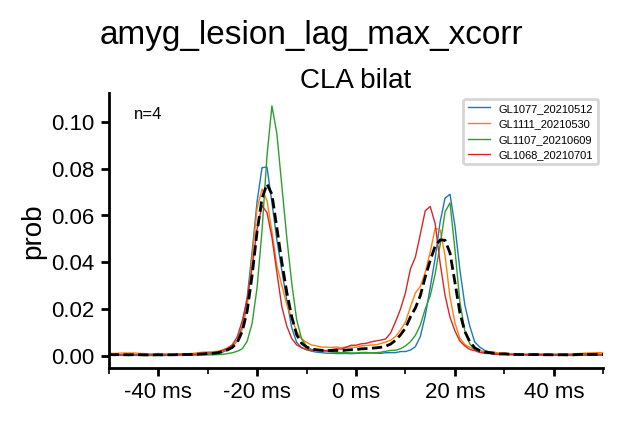

In [8]:
amyg_exp_names = [
    'GL1077_20210512',
    'GL1111_20210530',
    'GL1107_20210609',
    'GL1068_20210701',
]

fig5.plot_lesion_hists(
    reg,
    amyg_exp_names,
    fig_desc='amyg_lesion_lag_max_xcorr',
    min_xcorr_q=MIN_XCORR_Q,
    use_cache=USE_CACHE,
)

# X-Corr (Fig. 5 c)

In [13]:
%%time

exp_name = 'GL1035_20210803'

exp_xcorr = reg.load_exp_xcorr_combs([exp_name], sliding_win=10_000, suffix='')

exp_xcorr

load x-corr:   0%|          | 0/1 [00:00<?, ?it/s]

loading /gpfs/laur/data/fenkl/spikes/neuronexus_bilateral/2021-08-03_17-50-52_GL1035/swsort/xcorr_p0c32_p1c64_w10000_40hz.h5
CPU times: user 52.4 ms, sys: 6.52 s, total: 6.57 s
Wall time: 13.5 s


pair              exp
0  CLA bilat  GL1035_20210803

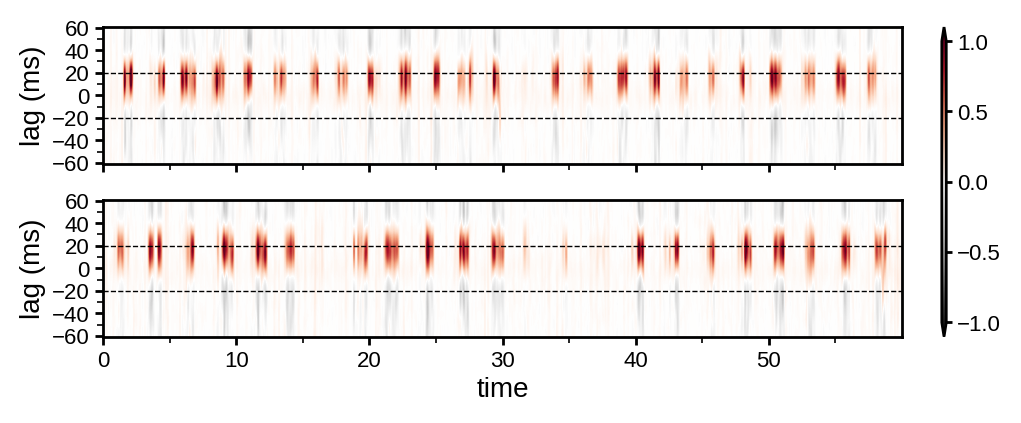

In [14]:
zoom_wins = [
    Win(9480000.0, 13080000.0),
    Win(27785000.0, 31385000.0),
]

axs = fig5.plot_example_lesion_xcorr(
    exp_xcorr.get(exp=exp_name, pair='CLA bilat').sel_between(lag=(-60, +60)),
    zoom_wins=zoom_wins,
)

axs.ravel()[0].figure.savefig(f'figs/{exp_name}_{int(zoom_wins[0].start)}_{int(zoom_wins[-1].stop)}.pdf')

## X-corr vs beta (EDF8 a)

In [19]:
exp_beta = fig5.load_exp_all_beta_norm_to_min(reg, ['GL1035_20210803'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

saving figs/GL1035_20210803_xcorr_with_beta_0.pdf
saving figs/GL1035_20210803_xcorr_with_beta_1.pdf
saving figs/GL1035_20210803_xcorr_with_beta_2.pdf


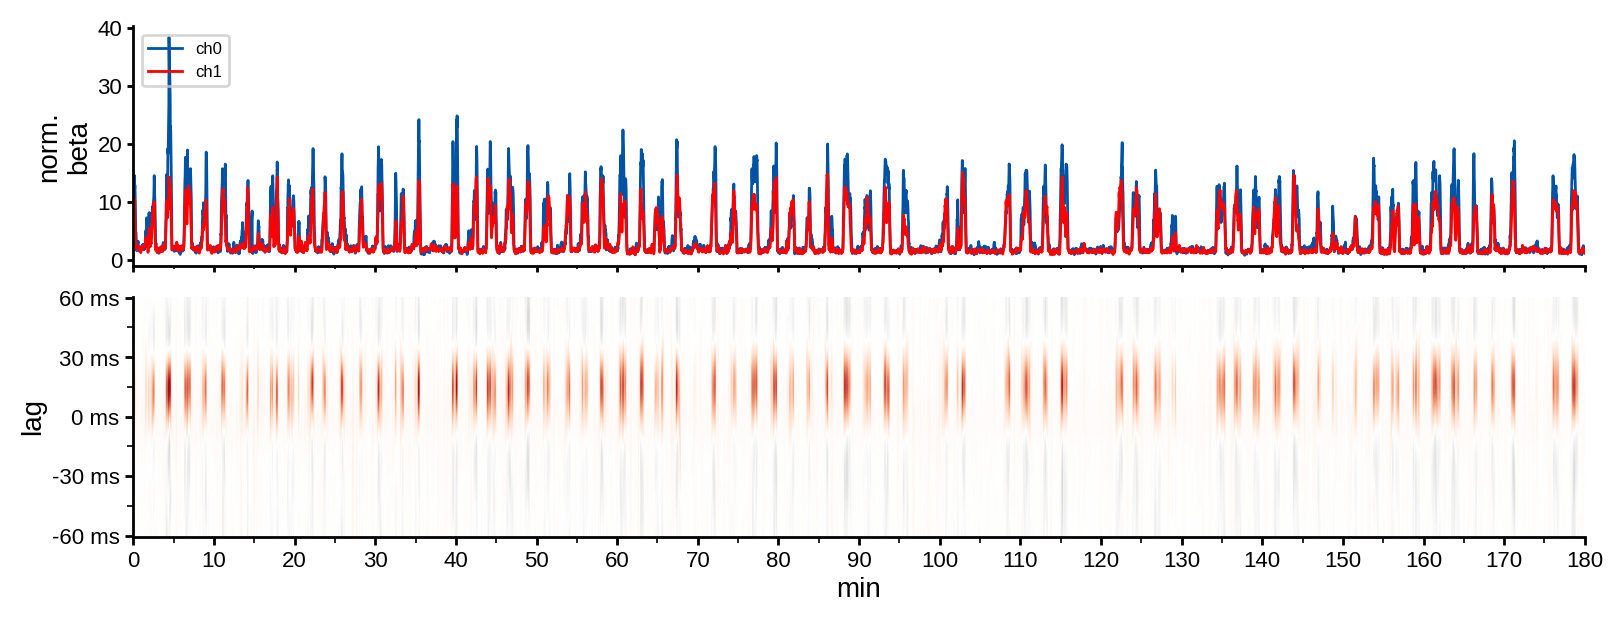

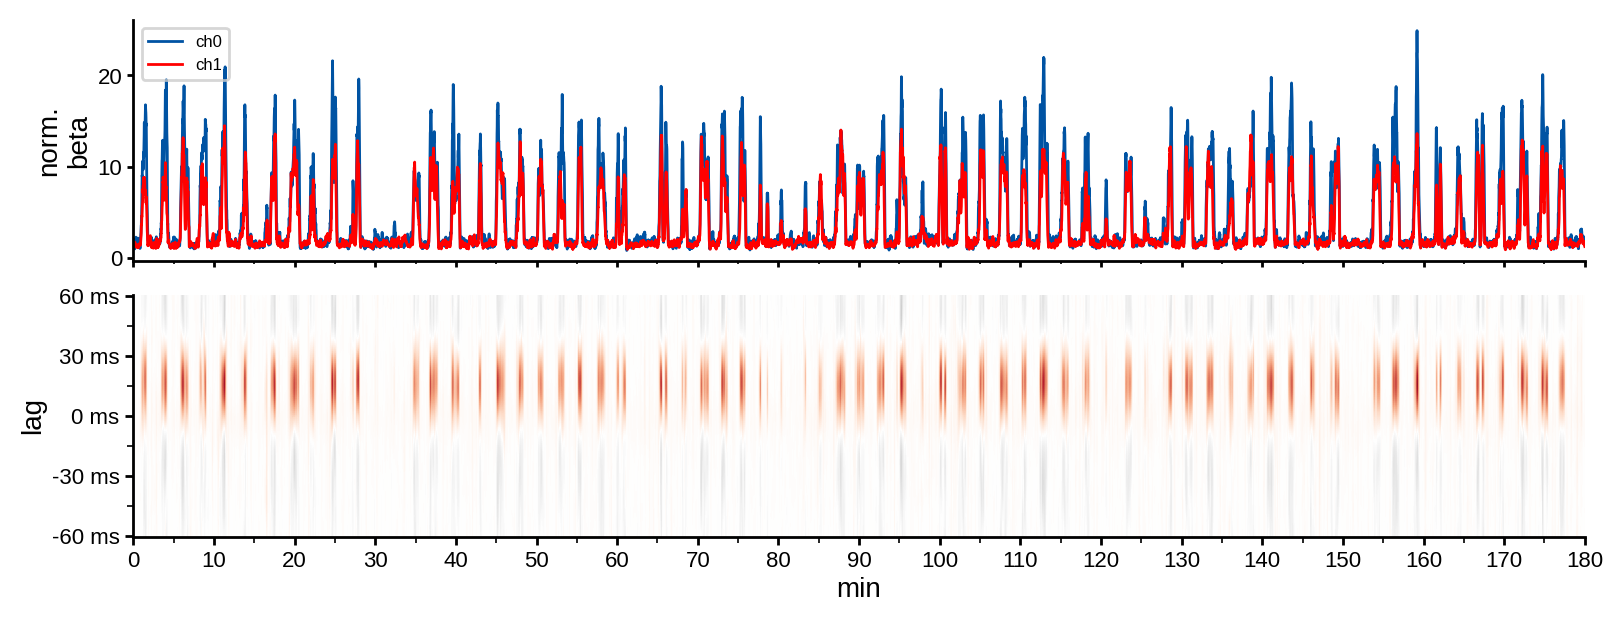

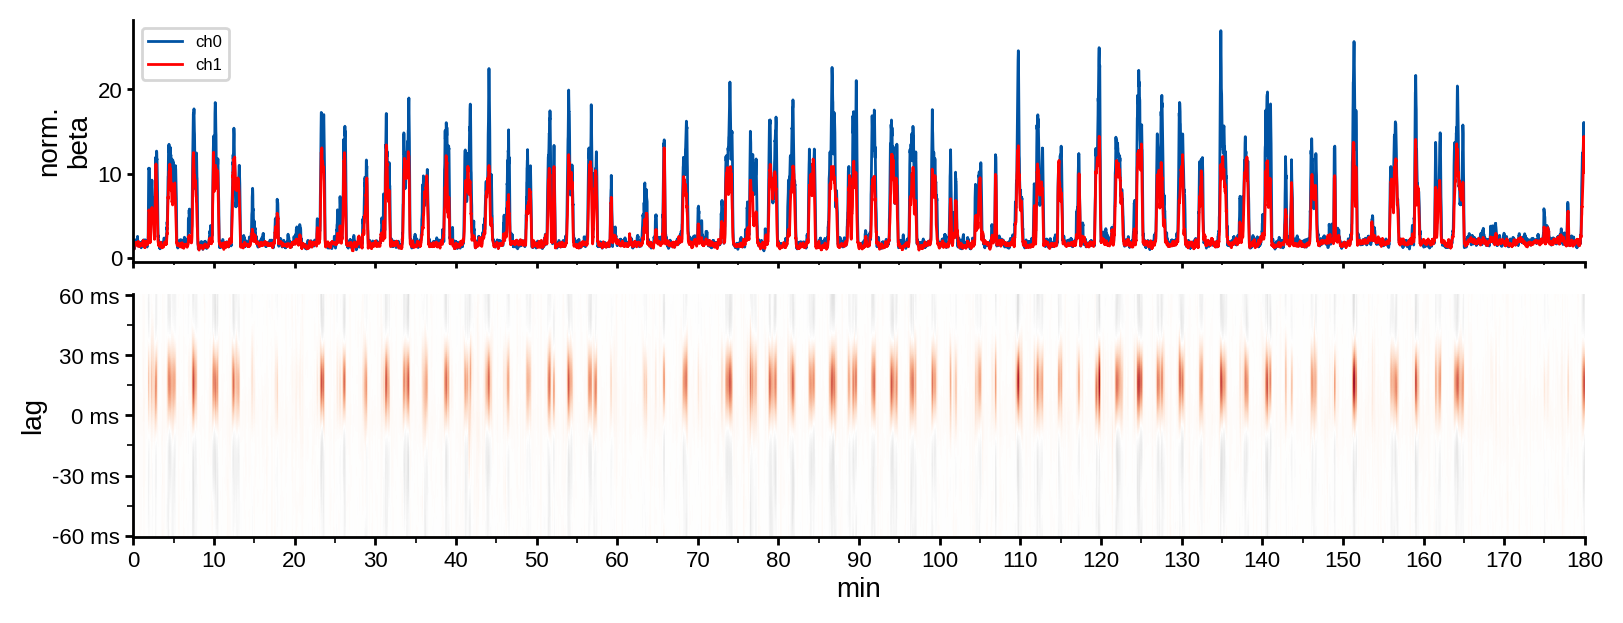

In [16]:
exp_zoom_wins_ms = {
    'GL1035_20210803': [
        Win(ms(hours=2+3*0), ms(hours=2+3*1)),
        Win(ms(hours=2+3*1), ms(hours=2+3*2)),
        Win(ms(hours=2+3*2), ms(hours=2+3*3)),
    ]
}

for exp_name, zoom_wins_ms in pbar(exp_zoom_wins_ms.items()):
    loader = reg.get_loader(exp_name)

    for i, zoom_win in enumerate(zoom_wins_ms):
        axs = fig5.plot_xcorr_sel(
            exp_xcorr.get(exp=exp_name, pair='CLA bilat'),
            zoom_win,
            exp_beta[exp_name],
            downsample=1,
            major=ms(minutes=10),
        )
        path = f'figs/{exp_name}_xcorr_with_beta_{i}.pdf'.replace(' ', '_').replace('-', '_')
        print(f'saving {path}')
        axs[0].figure.savefig(path)

# REM lasts longer or shorter, more or less?

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

cond:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

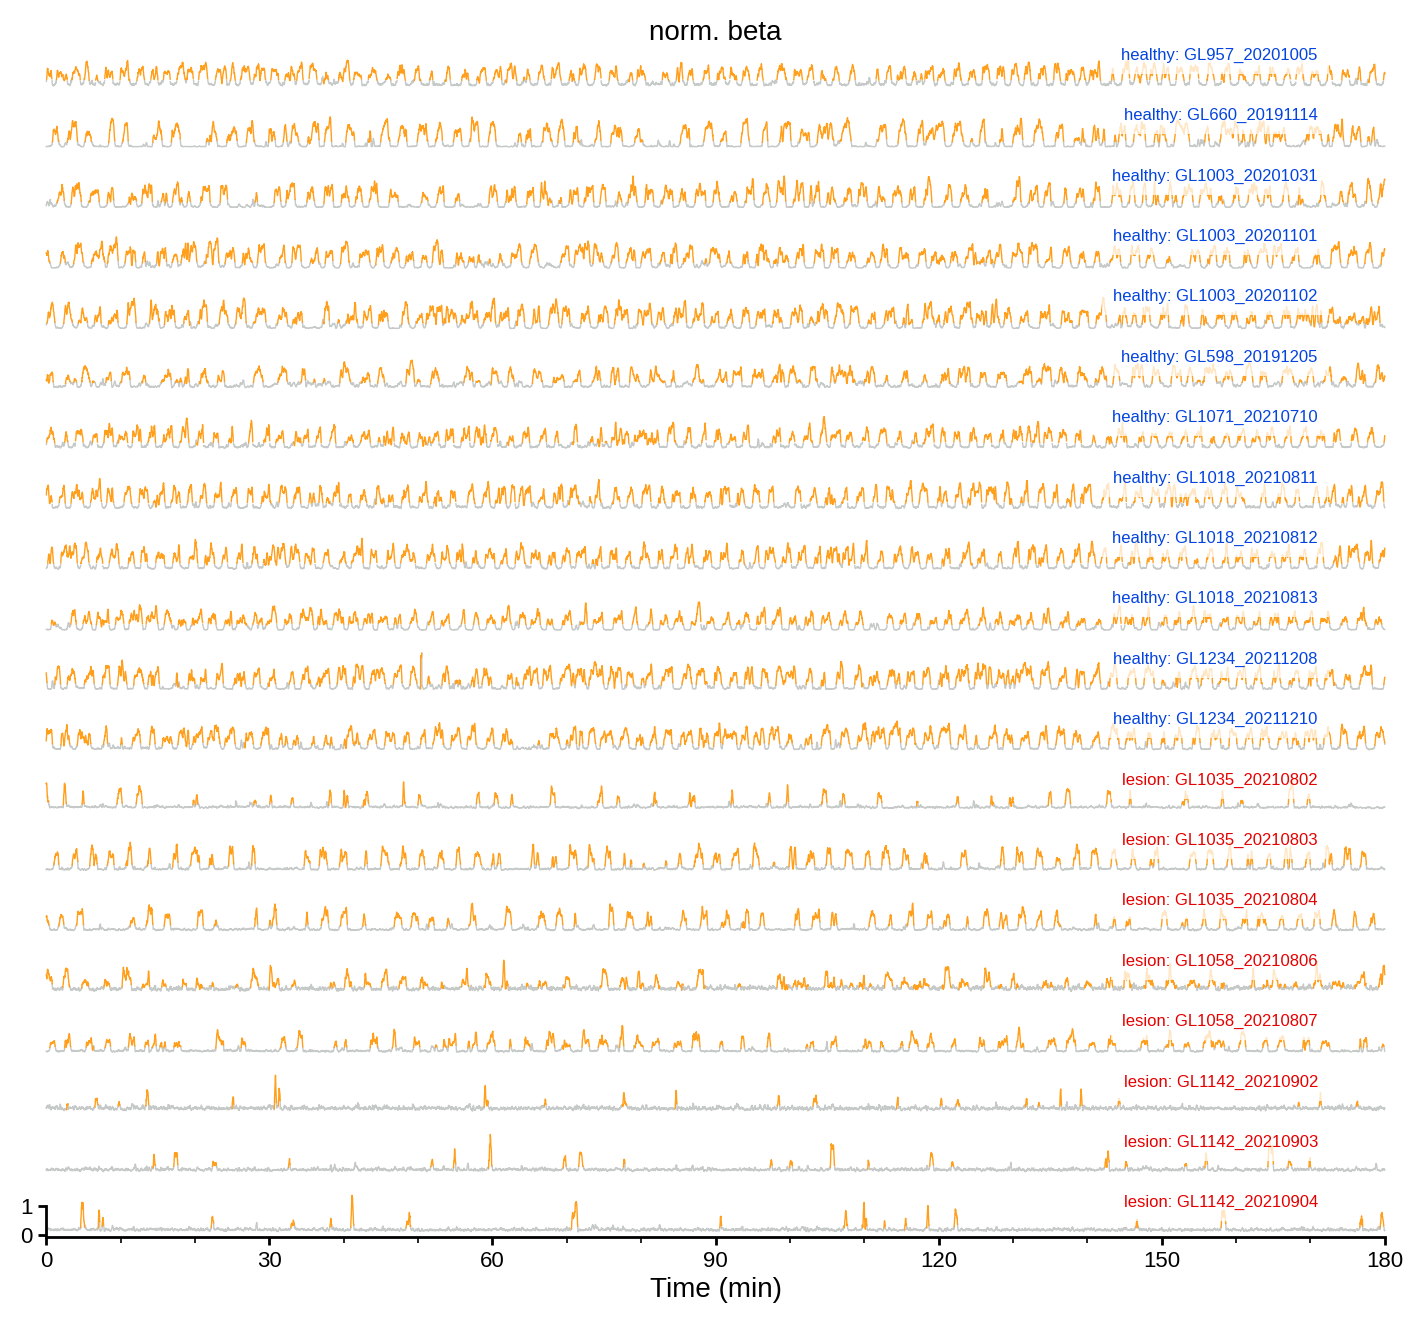

In [17]:
exp_comp = {
    'lesion': [
        'GL1035_20210802',
        'GL1035_20210803',
        'GL1035_20210804',

        'GL1058_20210806',
        'GL1058_20210807',

        'GL1142_20210902',
        'GL1142_20210903',
        'GL1142_20210904',

    ],
    'healthy': [
        'GL957_20201005',
        'GL660_20191114',
        'GL1003_20201031',
        'GL1003_20201101',
        'GL1003_20201102',
        'GL598_20191205',
        'GL1071_20210710',
        'GL1018_20210811',
        'GL1018_20210812',
        'GL1018_20210813',
        'GL1234_20211208',
        'GL1234_20211210',        
    ]
}

valid_win = Win(ms(hours=2), ms(hours=2+9))

exp_betas, exp_remsws_wins = fig5.load_all_exp_remsws_wins(reg, exp_comp, valid_win)

exp_colors = {}
for _, names in exp_betas.reg.groupby('cond')['exp_name']:
    for i, exp_name in enumerate(names):
        exp_colors[exp_name] = f'C{i}'
        

f = fig5.plot_beta_by_rem_state_all(exp_betas, exp_remsws_wins, shown_win=Win.build_centered(ms(hours=6.5), ms(hours=3)))

In [18]:
stats_rem = fig5.collect_rem_stats(exp_remsws_wins, cat='rem')
fig5.txt_describe_rem_stats(stats_rem, which='mean', cat='rem')
fig5.txt_describe_rem_stats(stats_rem, which='total', cat='rem')

  0%|          | 0/20 [00:00<?, ?it/s]

healthy mean rem 00:01:04.965, lesion mean rem 00:00:32.881; P=0.000028, t=-6.992; Welch's t-test
healthy total rem 04:39:51.500, lesion total rem 01:37:14.250; P=0.000062, t=-7.205; Welch's t-test
